# Westeros bis - emissions introduction and analysis

Comparing the three scenarios with the following energy mixes at year 690
- 60% share of coal and 00% gas generation (``westeros_bis_baseline.ipynb``)
- 40% share of coal and 20% gas generation (``westeros_bis_energymix1.ipynb``)
- 20% share of coal and 40% gas generation (``westeros_bis_energymix2.ipynb``)
It has been observed a decreasing total cost of the system and price of electricity.

Even though the ``westeros_bis_energymix2.ipynb`` is closer to the modern energy portfolio, the second ``westeros_bis_energymix1.ipynb`` will be considered because of a more dynamic profile of coal capacity, and will be the base for the implementation of:
- emission impact of gas and coal
- emissions cap of 700 Mt of CO2.

### Pre-requisites
- You have the MESSAGEix framework installed and working
- You have run (``westeros_bis_baseline.ipynb``) scenario and solved it successfully
- You have run (``westeros_bis_energymix1.ipynb``) scenario

In [1]:
import pandas as pd
import ixmp
import message_ix

from message_ix.util import make_df

%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
mp = ixmp.Platform()

Recalling the model

In [3]:
model = 'Westeros Electrified'
base = message_ix.Scenario(mp, model=model, scenario='energy mix1')

Creating emission scenario by cloning energy mix 1

In [4]:
scen_em1 = base.clone(model, 'emissions1','adding emissions cap',
                  keep_solution=False)
scen_em1.check_out()

In [5]:
year_df = scen_em1.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen_em1.set('year') 
country = 'Westeros'

Introducing emissions category, parameter, and value for coal and gas technology

In [6]:
# first we introduce the emission of CO2 and the emission category GHG
scen_em1.add_set('emission', 'CO2')
scen_em1.add_cat('emission', 'GHG', 'CO2')

# we now add CO2 emissions to the coal powerplant
base_emission_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'unit': 'tCO2/kWa',
}

# adding new units to the model library (needed only once)
mp.add_unit('tCO2/kWa')
mp.add_unit('MtCO2')

INFO:root:unit `tCO2/kWa` is already defined in the platform instance
INFO:root:unit `MtCO2` is already defined in the platform instance


In [7]:
emission_factor = { # values from https://doi.org/10.1016/B978-0-8155-2049-8.10007-5 converted to tCO2/kWa
    'coal_ppl': 7.07, 
    'ngcc_ppl': 3.11,
    'wind_ppl': 0,
}

for tec, val in emission_factor.items():
    df = make_df(base_emission_factor, technology=tec, value=val, emission='CO2')
    scen_em1.add_par('emission_factor', df)

Introducing an upper bound

In [8]:
scen_em1.add_par('bound_emission', [country, 'GHG', 'all', 'cumulative'],
             value=700., unit='MtCO2')

Solving the model

In [9]:
scen_em1.commit(comment='introducing emissions and setting an upper bound')
scen_em1.set_as_default()

In [10]:
scen_em1.solve()

In [11]:
scen_em1.var('OBJ')['lvl']

409672.09375

Plotting the results

In [12]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep = Reporter.from_scenario(scen_em1)
prepare_plots(rep)

Activity

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

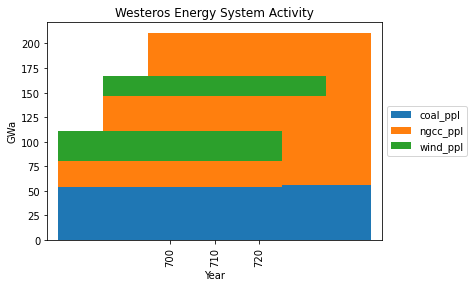

In [13]:
rep.set_filters(t=["coal_ppl", "wind_ppl","ngcc_ppl"])
rep.get("plot activity")

Capacity

<AxesSubplot:title={'center':'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

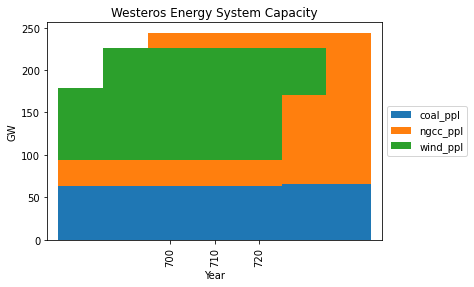

In [14]:
rep.get("plot capacity")

Electricy price

<AxesSubplot:title={'center':'Westeros Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

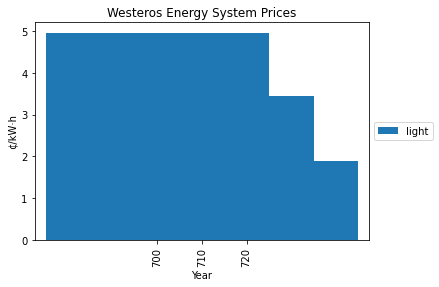

In [15]:
rep.set_filters(t=None, c=["light"])
rep.get("plot prices")

Take a more detailed look into carbon emissions by decade, and equivalent emission prices

In [16]:
emissions = scen_em1.var('EMISS', {'node': 'Westeros'})
emissions

,node,emission,type_tec,year,lvl,mrg
0,Westeros,CO2,all,700,463.083699,0.0
1,Westeros,CO2,all,710,759.609085,0.0
2,Westeros,CO2,all,720,877.307215,0.0


In [17]:
emission_prices = scen_em1.var('PRICE_EMISSION')
emission_prices

,node,type_emission,type_tec,year,lvl,mrg
0,Westeros,GHG,all,700,1.877639,0.0
1,Westeros,GHG,all,710,3.058476,0.0
2,Westeros,GHG,all,720,4.981935,0.0


# Comments on the results

In ``westeros_bis_emissions_cap1.ipynb`` with respect to ``westeros_bis_energymix1.ipynb``:
- total cost is just slightly higher, 409672.09375 against 408462.5625
- Coal technology activity is slightly decreased in the last decade, and the electricity price slightly increased in the same period.
- Gas technology is replacing the coal in the last decade, and wind technology activity is unchanged.

The relaxed emission cap allows a great emission production (almost unaffected with respect to scenario ``westeros_bis_energymix1.ipynb``) and extremely low carbon prices of (1.8, 3, 5) USD/tCO2 in the three decades.

Two similar scenarios will be analyzed with lower caps of 600 and 500 MtCO2.

Close connection to the database

In [18]:
mp.close_db()